In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import missingno as msno
import seaborn as sns
sns.set(style="whitegrid")

In [2]:
#data = pd.read_csv('NEIPAfinal 2-20-2020.csv')
data = pd.read_csv('NEIPAfinal no NAs.csv')

In [3]:
#get list of column names for reference
print(data.columns)

Index(['recipeURL', 'name', 'author', 'dateCreated', 'urlProvided', 'views',
       'brews', 'OG', 'FG', 'ABV', 'IBU', 'SRM', 'mashpH', 'method', 'style',
       'boilTime', 'batchSize', 'preBoilSize', 'postBoilSize',
       'preBoilGravity', 'efficency', 'source', 'rating', 'ratingCount',
       'noChill', 'hopUtilization', 'calories', 'carbs', 'fermNames',
       'fermAmounts', 'fermPPGs', 'fermDegreeLovibond', 'fermPercentages',
       'hopNames', 'hopAmounts', 'hopForms', 'hopAAs', 'hopUses', 'hopTimes',
       'hopIBUs', 'hopPercentages', 'otherIngredients', 'otherAmounts',
       'otherTypes', 'otherUses', 'otherTimes', 'Ca', 'Mg', 'Na', 'Cl', 'SO4',
       'HCO3', 'primingInfo', 'yeastNames', 'yeastAmounts',
       'yeastAttenuations', 'yeastOptTemps', 'yeastFlocculations',
       'yeastStarters', 'yeastFermTemps', 'yeastPitchRates', 'notes'],
      dtype='object')


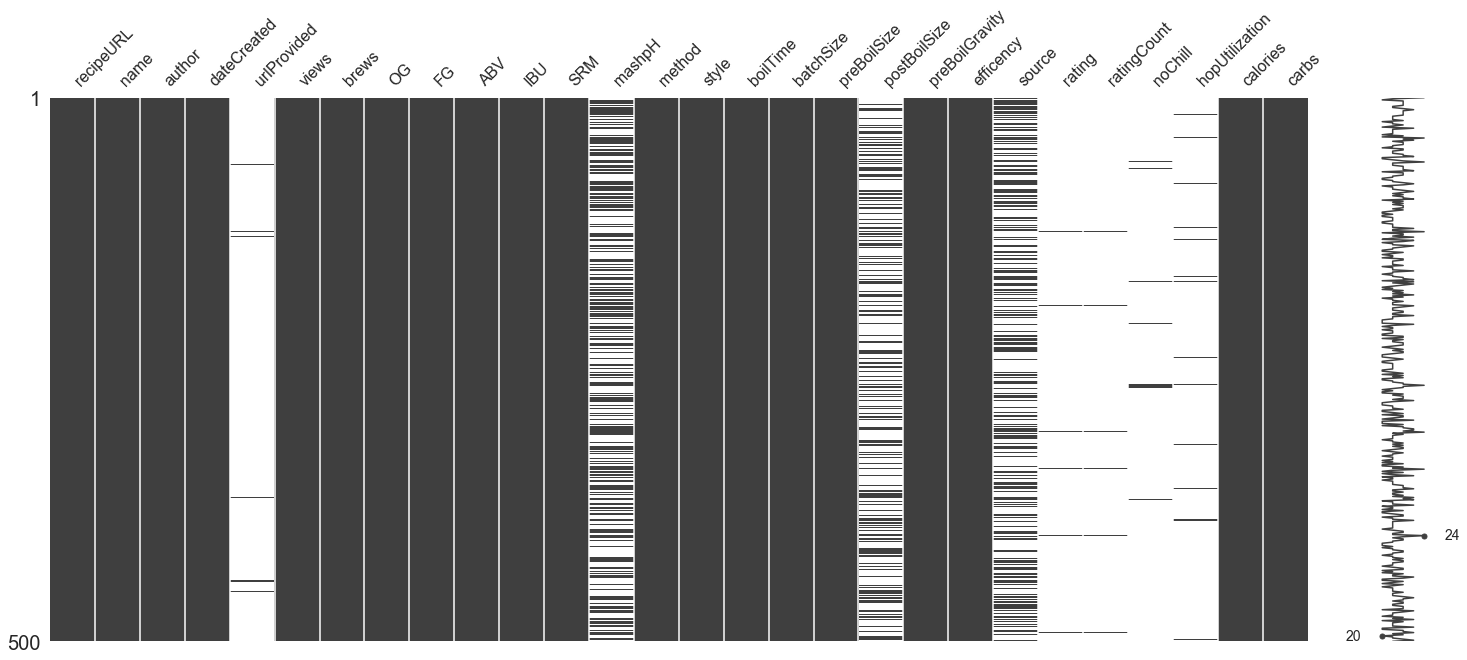

In [53]:
%matplotlib inline
msno.matrix(data.iloc[:,0:28].sample(500))

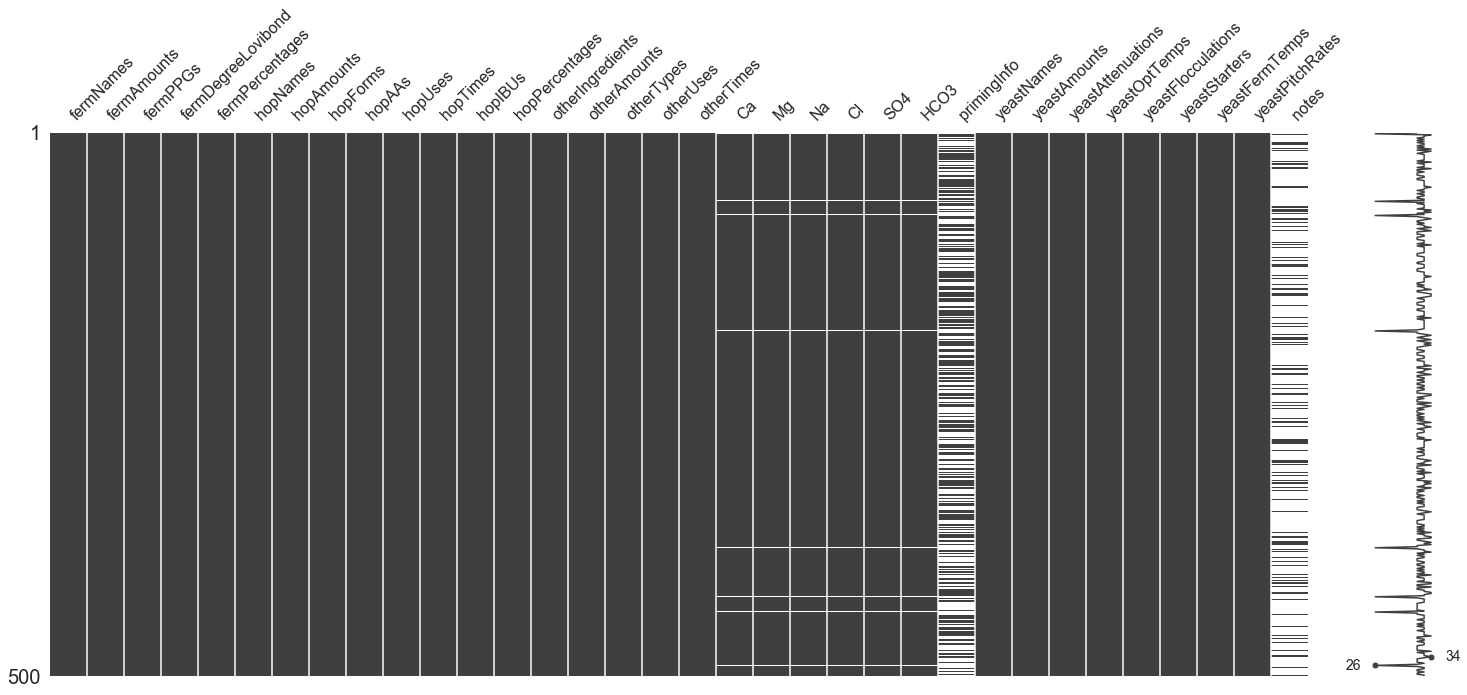

In [54]:
%matplotlib inline
msno.matrix(data.iloc[:,28:len(data.columns)].sample(500))

In [4]:
#og, fg, abv, ibu, srm, mashPh, boilTime, batchSize, preBoilSize, preBoilGravity, calories, carbs
#convert degrees plato to specific gravity if present
def platoToGravity(someList):
    gravity = []
    
    for g in someList:
        if ' °P' in str(g):
            dP = float(g.strip().split(' °P')[0])
            gravity.append( round(1 + (dP/(258.6 - ((dP/258.2)*227.1))),3))
        else: 
            gravity.append( float(g))
            
    return gravity

og = platoToGravity(data.OG)  
fg = platoToGravity(data.FG)
preBoilGravity = platoToGravity(data.preBoilGravity)

#remove % and convert to float
abv = [float(x.replace('%','')) for x in data.ABV]    
efficiency = [float(x.replace('%','')) for x in data.efficency]    
ibu = [float(x) for x in data.IBU]
srm = [float(x) for x in data.SRM]
mashPh = [float(x) for x in data.mashpH]
#remove min from string
boilTime = [float(x.split(' min')[0]) for x in data.boilTime]

#convert liters to gallons
#first check what units batchSize is recorded as
#units = set([x.split(' ')[1] for x in data.batchSize])
#units #(gallons and liters)

#there are 0.265172 gallons per liter
batchSize = list(map(lambda x: round(float(x.split(' ')[0])*0.264172,2) if x.split(' ')[1]=='liters' 
                                                else float(x.split(' ')[0]), data.batchSize))
preBoilSize = list(map(lambda x: round(float(x.split(' ')[0])*0.264172,2) if x.split(' ')[1]=='liters' 
                                                else float(x.split(' ')[0]), data.preBoilSize))
#many NA postBoilSize so we'll ignore for now
postBoilSize = list(map(lambda x: round(float(x.split(' ')[0])*0.264172,2) if (type(x)!=float and x.split(' ')[1]=='liters') 
                                                else (float(x.split(' ')[0] if (type(x)!=float and x.split(' ')[1]=='gallons')
                                                           else float(x))), data.postBoilSize))

#parse number out of string
calories = [int(x.split()[1].replace(',','')) for x in data.calories]
carbs = [int(x.split()[1].replace(',','')) for x in data.carbs]
views = [int(x.replace(',','')) for x in data.views]
brews = [int(x) for x in data.brews]

numericalFeatures = pd.DataFrame({'og':og,'fg':fg,'preBoilGravity':preBoilGravity,'abv':abv,'efficiency':efficiency,
                                  'ibu':ibu,'srm':srm,'mashPh':mashPh,'boilTime':boilTime,'batchSize':batchSize,
                                  'preBoilSize':preBoilSize,'postBoilSize':postBoilSize,
                                  'calories':calories,'carbs':carbs,'views':views,'brews':brews})
numericalFeatures.head()

,og,fg,preBoilGravity,abv,efficiency,ibu,srm,mashPh,boilTime,batchSize,preBoilSize,postBoilSize,calories,carbs,views,brews
0,1.005,1.005,1.005,0.00,70.0,0.00,0.38,NaN,60.0,7.40,7.50,6.5,17,4,19,0
1,1.001,1.000,1.001,0.12,75.0,0.00,0.21,NaN,60.0,6.87,8.45,7.4,2,0,14,0
2,1.003,1.001,1.002,0.29,75.0,1471.32,0.60,NaN,60.0,5.49,7.50,NaN,9,1,169,0
3,1.004,1.000,1.003,0.53,35.0,118.07,1.40,NaN,60.0,5.50,6.50,NaN,11,0,95,0
4,1.007,1.003,1.004,0.62,35.0,0.00,1.73,NaN,60.0,3.96,6.60,NaN,22,3,134,0


In [104]:
numericalFeatures.describe().T

,count,mean,std,min,25%,50%,75%,max
og,2847.0,1.065782,0.016788,1.001,1.060,1.065,1.072,1.500
fg,2847.0,1.015959,0.005427,0.998,1.013,1.016,1.018,1.125
preBoilGravity,2847.0,1.054129,0.022071,1.001,1.046,1.052,1.059,1.500
abv,2847.0,6.547422,1.721812,0.000,5.940,6.480,7.130,54.720
efficiency,2847.0,70.461222,8.264557,25.000,68.000,70.000,75.000,100.000
ibu,2847.0,52.003727,49.637129,0.000,28.450,46.350,65.375,1471.320
srm,2847.0,5.892350,3.304526,0.000,4.510,5.340,6.380,50.000
mashPh,1449.0,5.570469,0.286413,1.330,5.430,5.660,5.730,6.210
boilTime,2847.0,60.493853,12.312054,1.000,60.000,60.000,60.000,150.000
batchSize,2847.0,25.135467,91.398625,0.740,5.490,5.550,8.545,1585.030


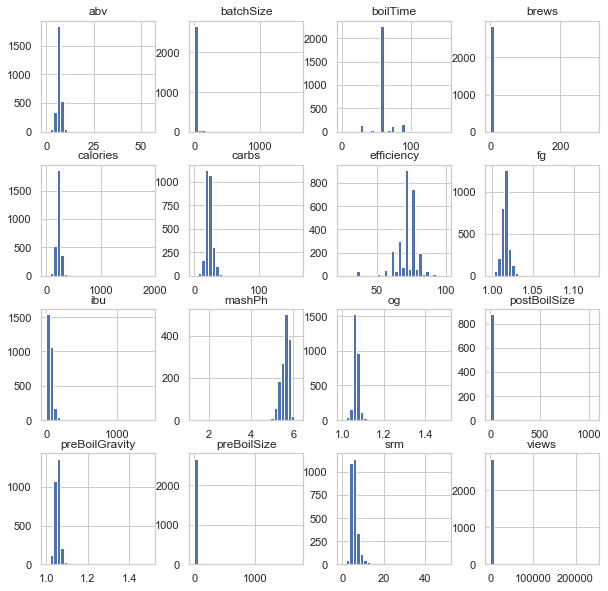

In [8]:
hist = numericalFeatures.hist(bins=30,figsize =(10,10))

In [120]:
 numericalFeatures.columns

Index(['og', 'fg', 'preBoilGravity', 'abv', 'efficiency', 'ibu', 'srm',
       'mashPh', 'boilTime', 'batchSize', 'preBoilSize', 'postBoilSize',
       'calories', 'carbs', 'views', 'brews'],
      dtype='object')

C:\Users\Theron\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


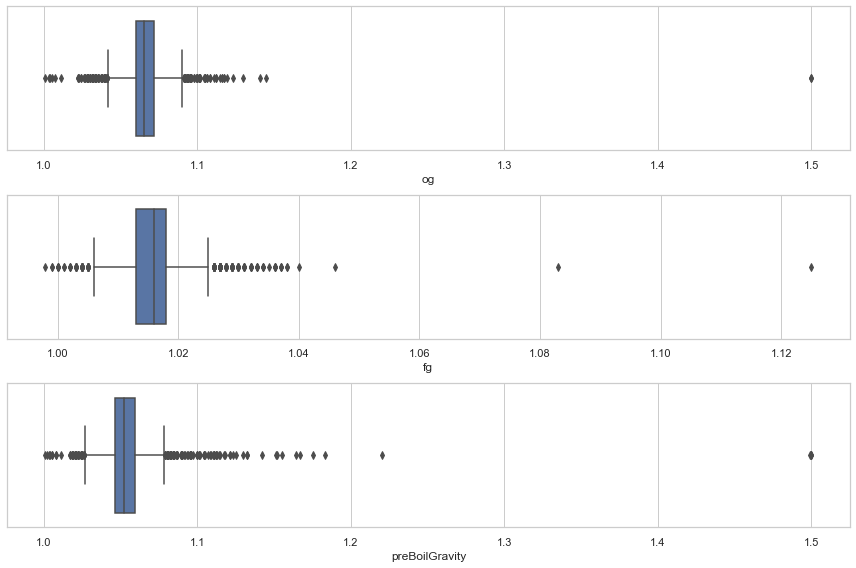

In [138]:
#plot gravities
fig, ax =plt.subplots(3,1,figsize=(12, 8))
sns.boxplot(numericalFeatures['og'], ax=ax[0])
sns.boxplot(numericalFeatures['fg'], ax=ax[1])
sns.boxplot(numericalFeatures['preBoilGravity'], ax=ax[2])
plt.tight_layout()
fig.show()

C:\Users\Theron\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


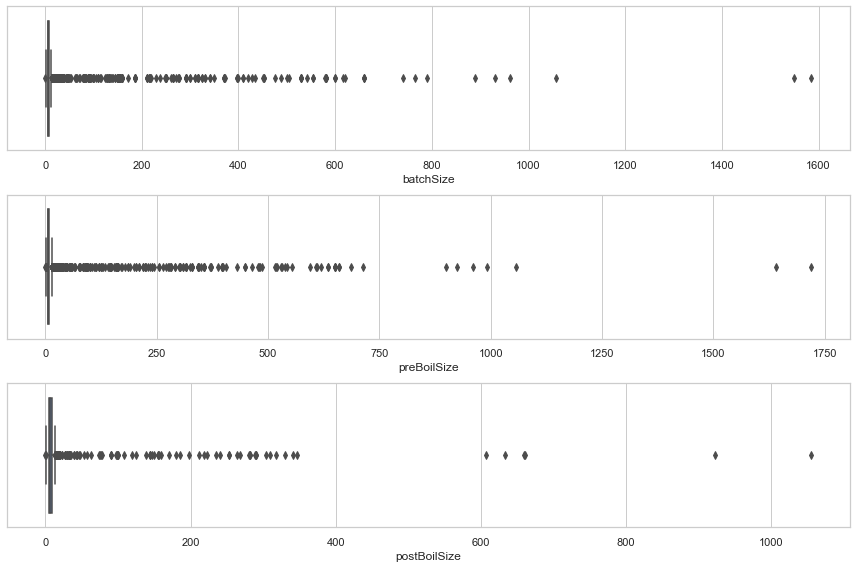

In [139]:
#plot sizes
fig, ax =plt.subplots(3,1,figsize=(12, 8))
sns.boxplot(numericalFeatures['batchSize'], ax=ax[0])
sns.boxplot(numericalFeatures['preBoilSize'], ax=ax[1])
sns.boxplot(numericalFeatures['postBoilSize'], ax=ax[2])
plt.tight_layout()
fig.show()

C:\Users\Theron\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


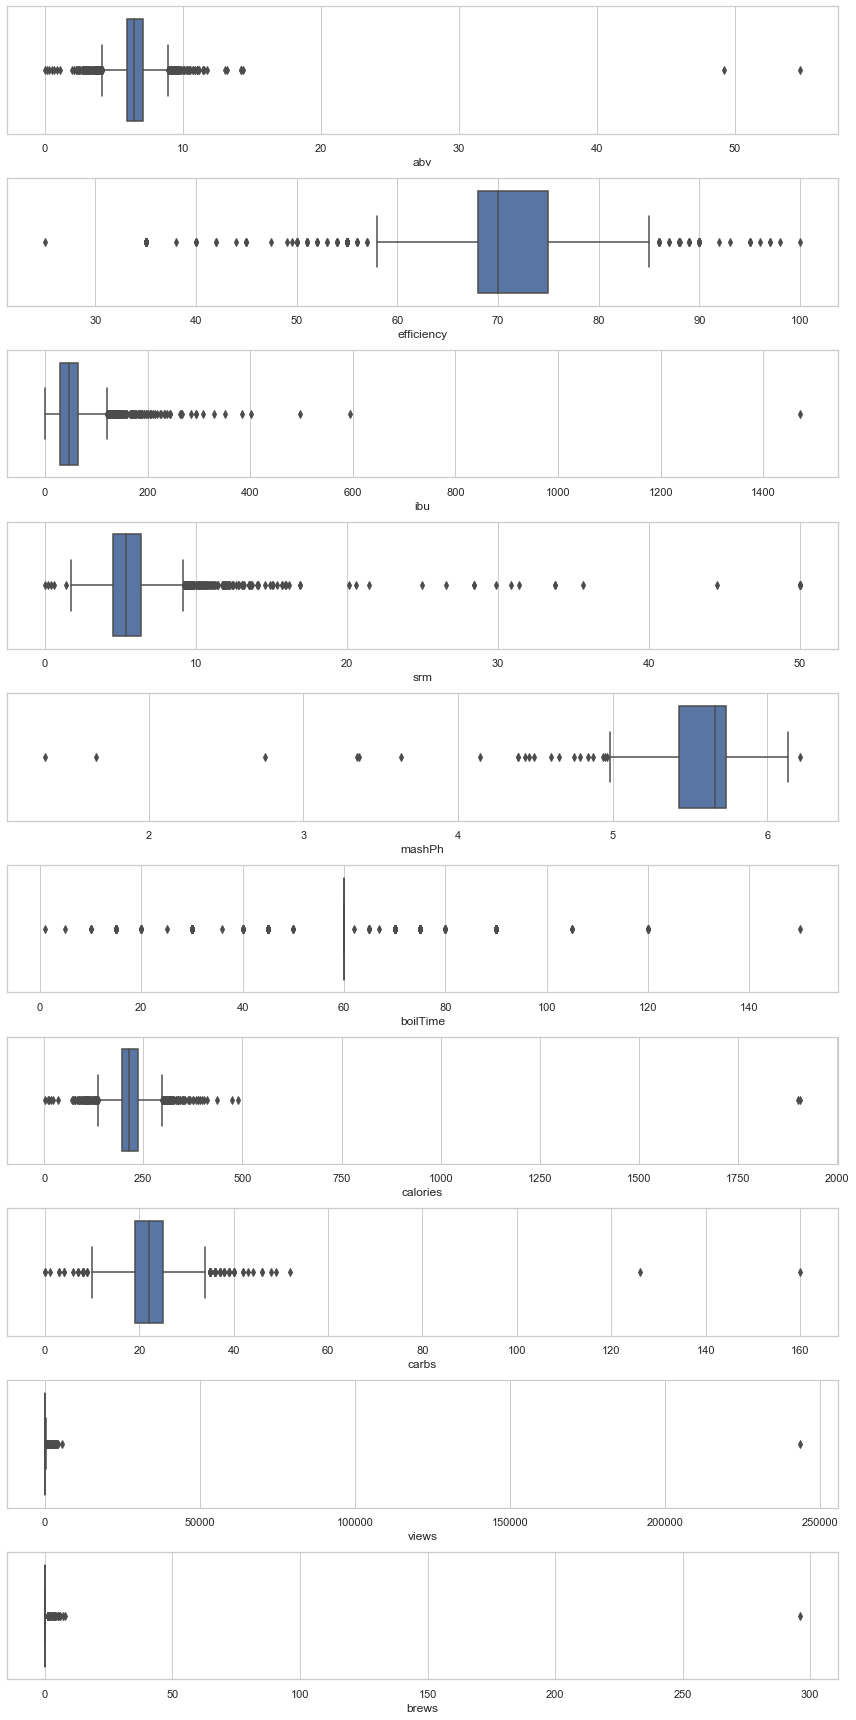

In [142]:
#plot remaining features
fig, ax =plt.subplots(10,1,figsize=(12, 24))
sns.boxplot(numericalFeatures['abv'], ax=ax[0])
sns.boxplot(numericalFeatures['efficiency'], ax=ax[1])
sns.boxplot(numericalFeatures['ibu'], ax=ax[2])
sns.boxplot(numericalFeatures['srm'], ax=ax[3])
sns.boxplot(numericalFeatures['mashPh'], ax=ax[4])
sns.boxplot(numericalFeatures['boilTime'], ax=ax[5])
sns.boxplot(numericalFeatures['calories'], ax=ax[6])
sns.boxplot(numericalFeatures['carbs'], ax=ax[7])
sns.boxplot(numericalFeatures['views'], ax=ax[8])
sns.boxplot(numericalFeatures['brews'], ax=ax[9])
plt.tight_layout()
fig.show()

In [ ]:
hist = df.hist(bins=10,figsize =(10,10))

C:\Users\Theron\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Theron\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


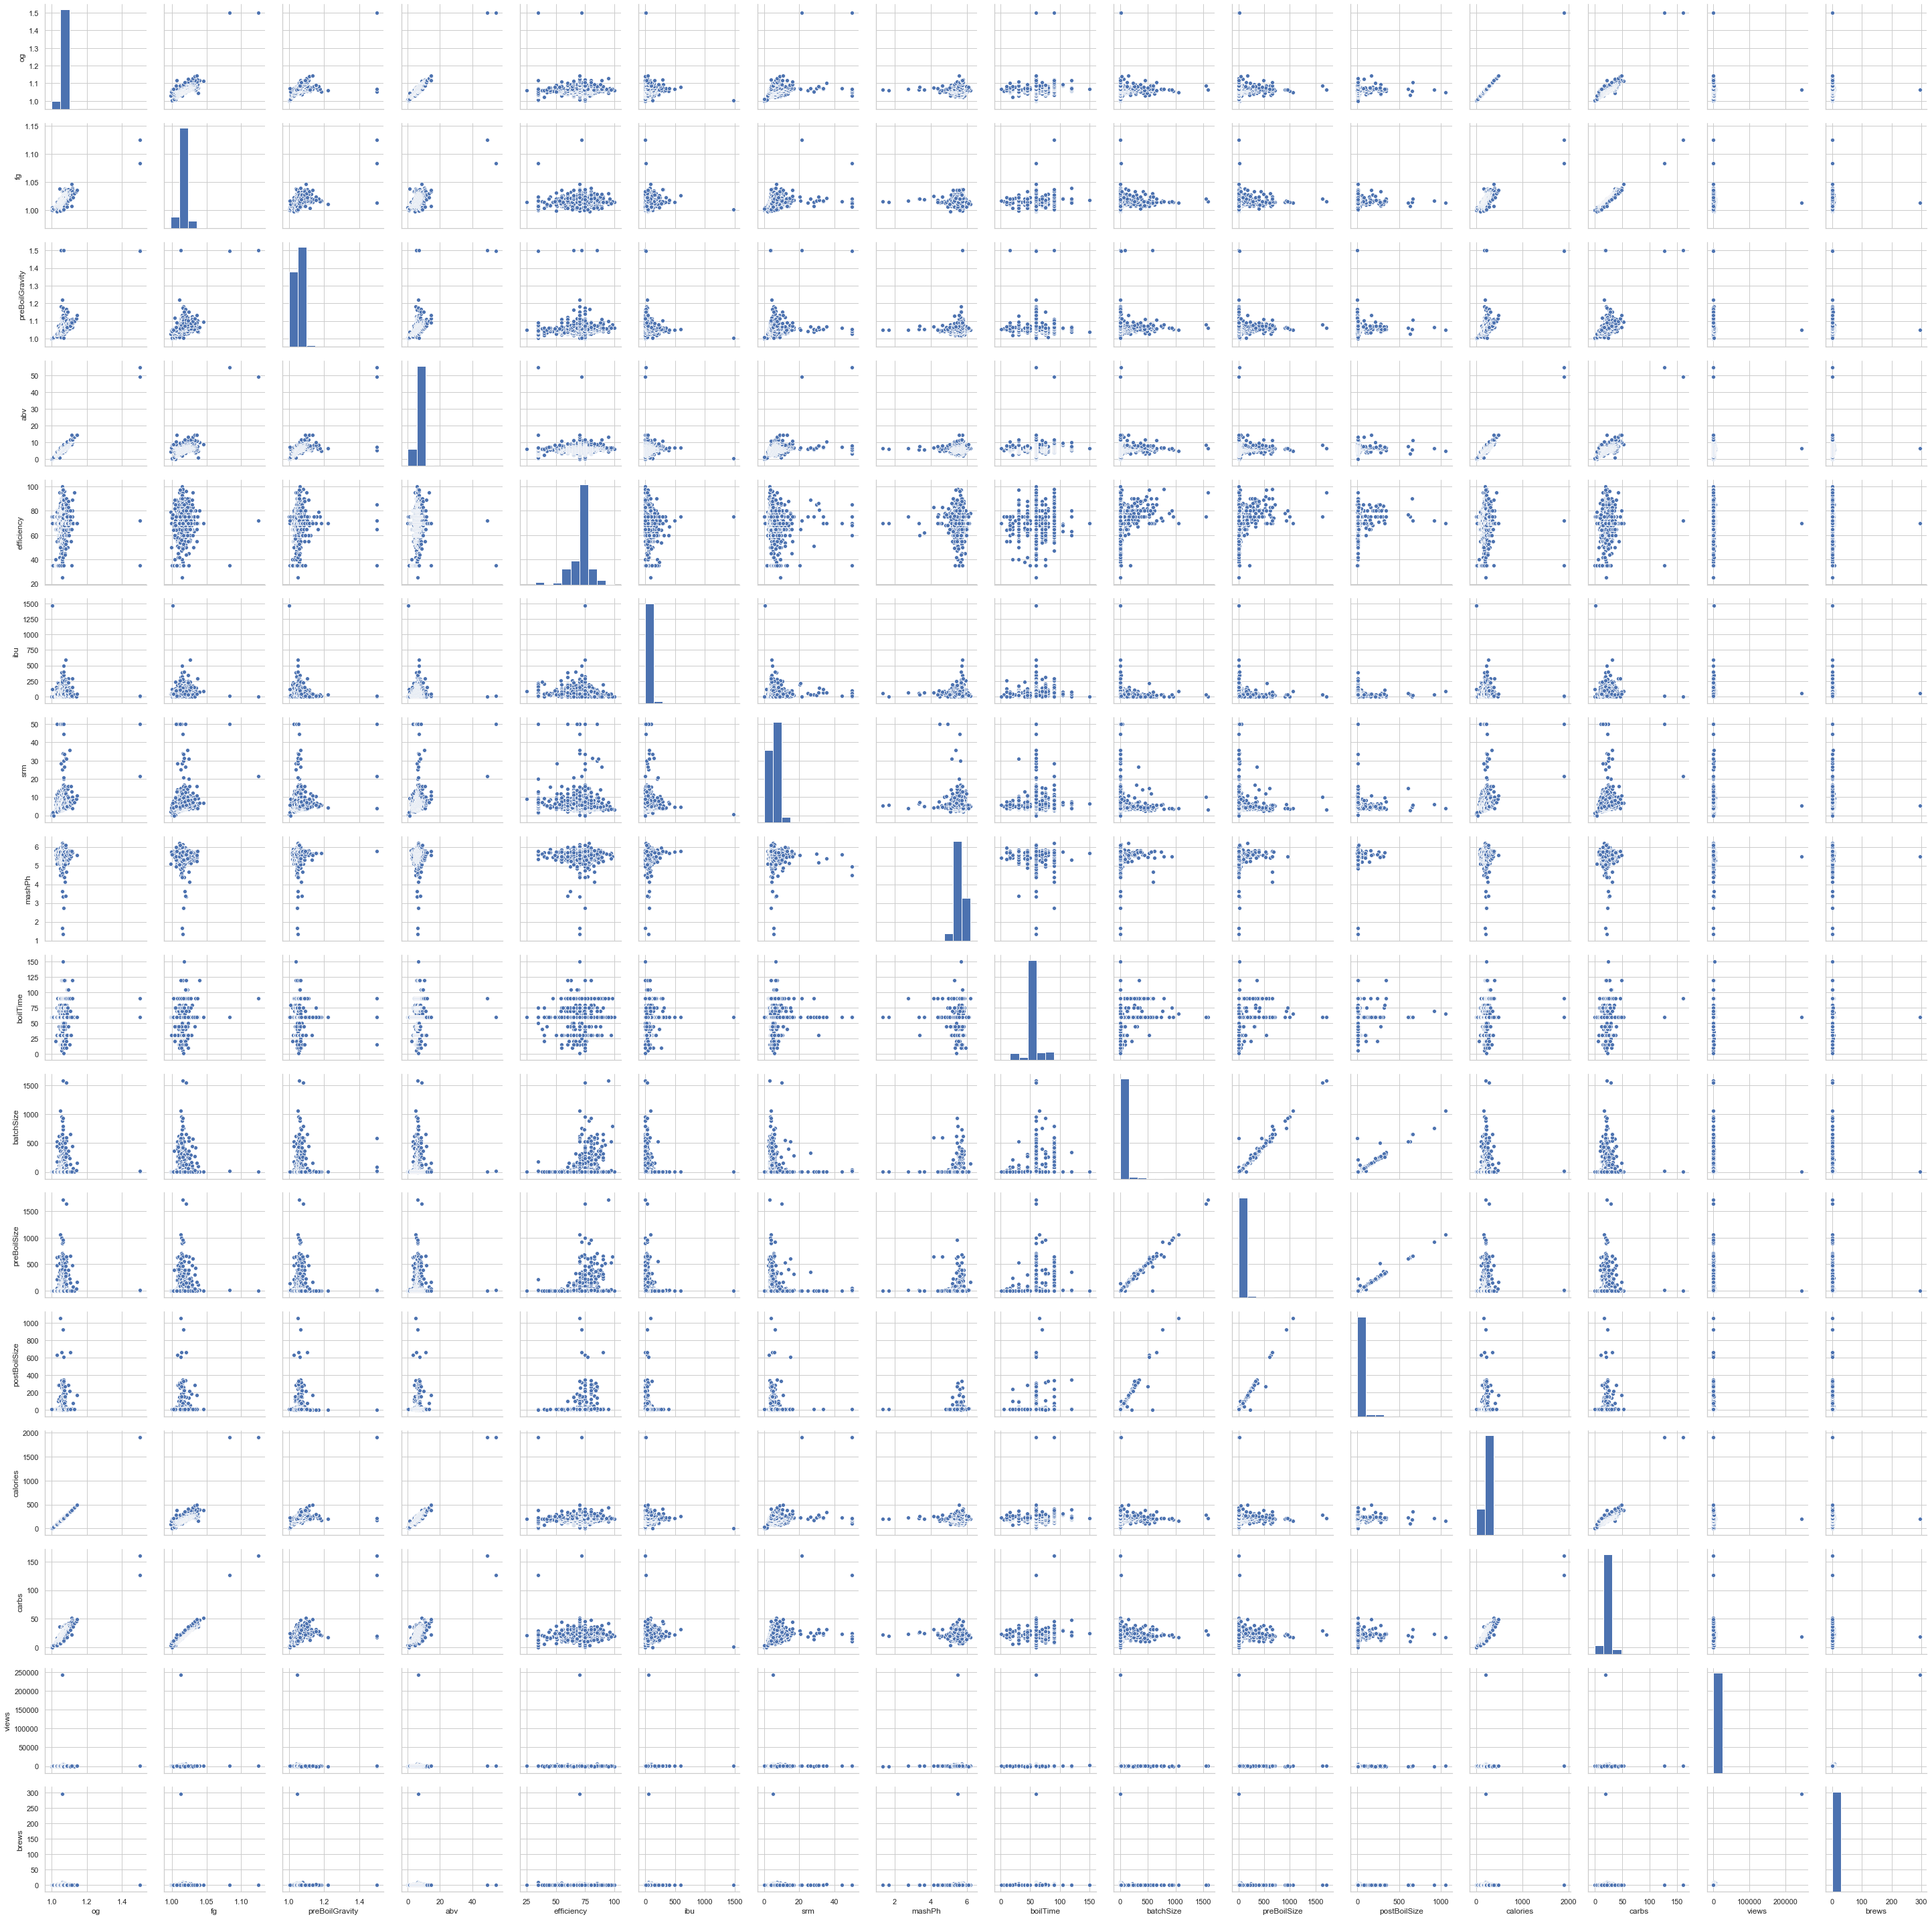

In [135]:
sns.pairplot(numericalFeatures)

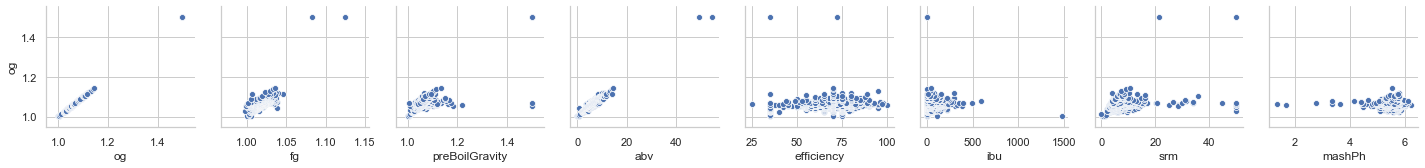

In [145]:
sns.pairplot(numericalFeatures, y_vars=['og'], x_vars=numericalFeatures.columns[0:8])

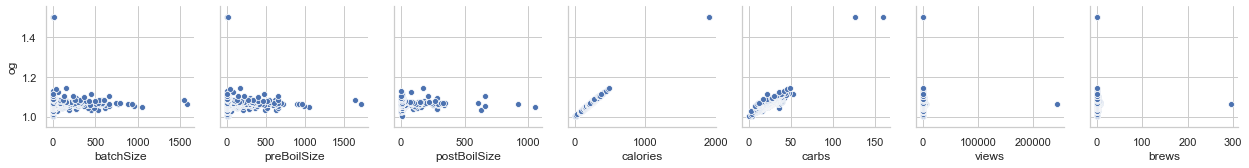

In [146]:
sns.pairplot(numericalFeatures, y_vars=['og'], x_vars=numericalFeatures.columns[9:16])

In [ ]:
#Standardize hop weights to oz
standardizedWeights = []
for i in range(0, len(data.hopAmounts)):
    wgts = []
    test_string = data.hopAmounts[i]
    tempType = re.findall(r'\'(.*?)\'', test_string)
    resType = list(map(str, tempType))
    for j in range(0, len(resType)):
        if 'kg' in resType[j]:
            wgt = resType[j].split(' kg')[0]
            wgt = float(wgt)*35.274 #convert to oz, 35.274 oz per kg
        elif 'g' in resType[j]:
            wgt = resType[j].split(' g')[0]
            wgt = float(wgt)*0.035274 #convert to oz, 0.0352 oz per g
        elif 'lb' in resType[j]:
            wgt = resType[j].split(' lb')[0]
            wgt = float(wgt)*16 #convert to oz, 16 oz per lb
        elif 'oz' in resType[j]:
            wgt = resType[j].split(' oz')[0]
            wgt = float(wgt)
        else:
            wgt = 'NA'
        
        wgts.append(wgt)

    standardizedWeights.append(wgts)

In [1]:
def getIngredientCounts(ingrSeries, ingrName):
    #get list of ingredients used (contains repeats)
    ingrList = []
    ingrSeries = ingrSeries.fillna('NA')

    #for each recipe, turn string of all ingredients into a list and add it to list of all fermentables used
    #this method assumes that each ingredient is only present once in each recipe
    for i in range(0,len(ingrSeries)):
        test_string = ingrSeries[i]
        tempType = re.findall(r'\'(.*?)\'', test_string)
        resType = list(map(str, tempType))    
        ingrList.append(resType)

    #create comprehensive list of unique hops used
    uniqueIngr = []
    for ingrs in ingrList:
        for ingr in ingrs:    
            if ingr not in uniqueIngr:
                uniqueIngr.append(ingr)

    print('Number of unique',ingrName,': ', len(uniqueIngr)) 

    #find number of recipes that each unique grain is used in.
    uniqueIngrCount = [0]*len(uniqueIngr)

    for i in range(0,len(ingrList)):
        for j in range(0,len(set(ingrList[i]))): #use set() to get set of hops for each recipe i.e set([1,1,2,2,3]) = [1,2,3]
            if ingrList[i][j] in uniqueIngr:
                uniqueIngrCount[uniqueIngr.index(ingrList[i][j])] = uniqueIngrCount[uniqueIngr.index(ingrList[i][j])]+1

    ingrPercentage = [x / len(ingrSeries) for x in uniqueIngrCount]            

    ingr_df = pd.DataFrame({ingrName:uniqueIngr,'Count':uniqueIngrCount, 'Percentage':ingrPercentage})
    ingr_df = ingr_df.sort_values('Count',ascending = False).reset_index(drop=True)
    
    return ingr_df

In [180]:
hopCount = getIngredientCounts(data.hopNames, 'Hops')
fermCount = getIngredientCounts(data.fermNames, 'Fermentables')
otherCount = getIngredientCounts(data.otherIngredients, 'Others')
dfCount = pd.concat([hopCount,fermCount,otherCount],axis=1)
dfCount[0:10]

Number of unique Hops :  603
Number of unique Fermentables :  473
Number of unique Others :  310


,Hops,Count,Percentage,Fermentables,Count,Percentage,Others,Count,Percentage
0,Citra,1586,0.557078,Flaked Oats,1887.0,0.662803,NA,1795.0,0.630488
1,Mosaic,1106,0.388479,American - Pale 2-Row,1224.0,0.429926,Gypsum,652.0,0.229013
2,Amarillo,596,0.209343,Flaked Wheat,826.0,0.290130,Calcium Chloride,338.0,0.118721
3,Galaxy,529,0.185810,American - White Wheat,496.0,0.174218,Calcium Chloride (dihydrate),225.0,0.079031
4,Simcoe,426,0.149631,United Kingdom - Maris Otter Pale,374.0,0.131366,Lactic acid,217.0,0.076221
5,El Dorado,410,0.144011,Canadian - Honey Malt,363.0,0.127503,Epsom Salt,205.0,0.072006
6,Centennial,279,0.097998,American - Carapils (Dextrine Malt),362.0,0.127151,Table Salt,157.0,0.055146
7,Cascade,275,0.096593,United Kingdom - Golden Promise,319.0,0.112048,Wyeast - Beer Nutrient,97.0,0.034071
8,Columbus,263,0.092378,American - Pilsner,271.0,0.095188,Whirlfloc,89.0,0.031261
9,NA,246,0.086407,American - Wheat,270.0,0.094837,Phosphoric acid,84.0,0.029505


In [202]:
#sns.barplot(dfCount['Hops'])
# plt.barh(list(style_cnt_other.index), style_cnt_other['Count'])
# style_cnt_other['Ratio'].plot(kind='barh', figsize=(12,6),)
# plt.title('Ratio of styles across dataset')
# sns.despine(left=True, bottom=True)
# plt.gca().invert_yaxis()
dfCount['Hops'][0:15]
sns.countplot(x='Hops',data=dfCount.iloc[:,0:15])

Error in callback <function flush_figures at 0x000001BC7869E8B8> (for post_execute):


KeyboardInterrupt: 

In [200]:
dfCount.iloc(1:2)

SyntaxError: invalid syntax (<ipython-input-200-88287a6b86e9>, line 1)

mean:  1.0657818756585882
median:  1.065
Std dev:  0.016785026285522597


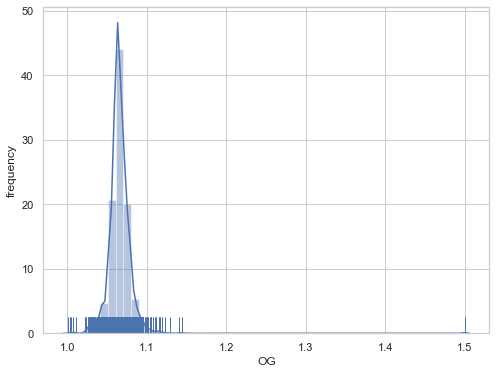

In [178]:
def plot_histogram(someList, featureName):
    fig, ax =plt.subplots(figsize=(8, 6))
    sns.distplot(someList, rug = True)

    plt.xlabel(featureName)
    plt.ylabel('frequency')

    print("mean: ", np.nanmean(someList))
    print("median: ", np.nanmedian(someList))
    print("Std dev: ", np.sqrt(np.nanvar(someList)))


plot_histogram(og, 'OG')
#plot_histogram(fg, 'FG')
# plot_histogram(data.ABV)
# plot_histogram(data.IBU)
# plot_histogram(data.mashpH)
# plot_histogram(data.SRM)
#plot_histogram(views, 'views')
#plot_histogram(data.brews)
#plt.tight_layout()

In [160]:
from collections import Counter 
data = pd.read_csv('creamAles.csv', encoding = "utf-8")

yeast = data.Yeast

count = Counter(yeast)
print(len(count)) #61
count.most_common()[0:10]

list

In [ ]:
#Standardize hop weights to oz
standardizedWeights = []
for i in range(0, len(data.hopAmounts)):
    wgts = []
    test_string = data.hopAmounts[i]
    tempType = re.findall(r'\'(.*?)\'', test_string)
    resType = list(map(str, tempType))
    for j in range(0, len(resType)):
        if 'kg' in resType[j]:
            wgt = resType[j].split(' kg')[0]
            wgt = float(wgt)*35.274 #convert to oz, 35.274 oz per kg
        elif 'g' in resType[j]:
            wgt = resType[j].split(' g')[0]
            wgt = float(wgt)*0.035274 #convert to oz, 0.0352 oz per g
        elif 'lb' in resType[j]:
            wgt = resType[j].split(' lb')[0]
            wgt = float(wgt)*16 #convert to oz, 16 oz per lb
        elif 'oz' in resType[j]:
            wgt = resType[j].split(' oz')[0]
            wgt = float(wgt)
        else:
            wgt = 'NA'
        
        wgts.append(wgt)

    standardizedWeights.append(wgts)
print('Checking conversions to ounces:')    
print(data.hopAmounts[38:41])
print(standardizedWeights[38:41])